In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## Loading Data
---

In [52]:
#Load data
mrt_df = pd.read_csv('../../data/oralytics_mrt_data.csv')
action_selection_df = pd.read_csv('../../data/action_selection_data_table.csv')
udpate_df = pd.read_csv('../../data/update_data_table.csv')
engineering_issues_mc = pd.read_csv('../../data/engineering_issues_main_controller.csv')
engineering_issues_rl = pd.read_csv('../../data/engineering_issues_rl.csv')

In [57]:
# remove NaN values
mrt_df = mrt_df[mrt_df['viability'] == 1]
# creating a new column called date 
mrt_df['date'] = pd.to_datetime(mrt_df['decision_time']).dt.strftime("%Y-%m-%d")

/var/folders/9n/sg342nsx01v38v7zgp161khr0000gn/T/ipykernel_24094/4197703041.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrt_df['date'] = pd.to_datetime(mrt_df['decision_time']).dt.strftime("%Y-%m-%d")


## Helper Functions
---

In [58]:
def get_user_data(df, user_id):
  return df[df['user_id'] == user_id]

def get_date(date_string):
    return datetime.strptime(date_string, '%Y-%m-%d').date()

def decision_day_to_day_in_study(curr_day, user_start_day):
    return (get_date(curr_day) - get_date(user_start_day)).days + 1

def construct_schedule_id(user_id, user_day_in_study):
    return "{}_day={}".format(user_id, user_day_in_study)

## Delayed Brushing Data
---
Brushing data could not appear in time for the current decision time, but comes in later (i.e., participant brushes but does not properly dock their toothbrush or dock is not stably connected to the internet). As part of trial protocol, we impute an OSCB value $Q_{i, t} = 0$ for that decision time and now inspect the percentage of decision times with delayed brushing data.

As part of the data cleaning procedure, rows marked with modification type 1 or 5 corresponds to delayed data.

In [59]:
delayed_data_rows = mrt_df[(mrt_df['modification_type'] == 1) | (mrt_df['modification_type'] == 5)]
print(f"{len(delayed_data_rows) / len(mrt_df)} decision times have delayed brushing data")

0.07012305465074195 decision times have delayed brushing data


## Staleness of Data
---

In [60]:
num_stale_states = 0
for i, row in mrt_df.iterrows():
    user_id = row['user_id']
    # check schedule id
    curr_day = row['decision_time'].split()[0]
    user_day_in_study = decision_day_to_day_in_study(curr_day, row['user_start_day'])
    num_stale_states += row['schedule_id'] != construct_schedule_id(user_id, user_day_in_study)

In [61]:
num_stale_states

8976

In [62]:
print(f"{num_stale_states / len(mrt_df)} decision times are stale.")

0.8121606948968513 decision times are stale.


## Engineering Issues
---

### Fallback Methods

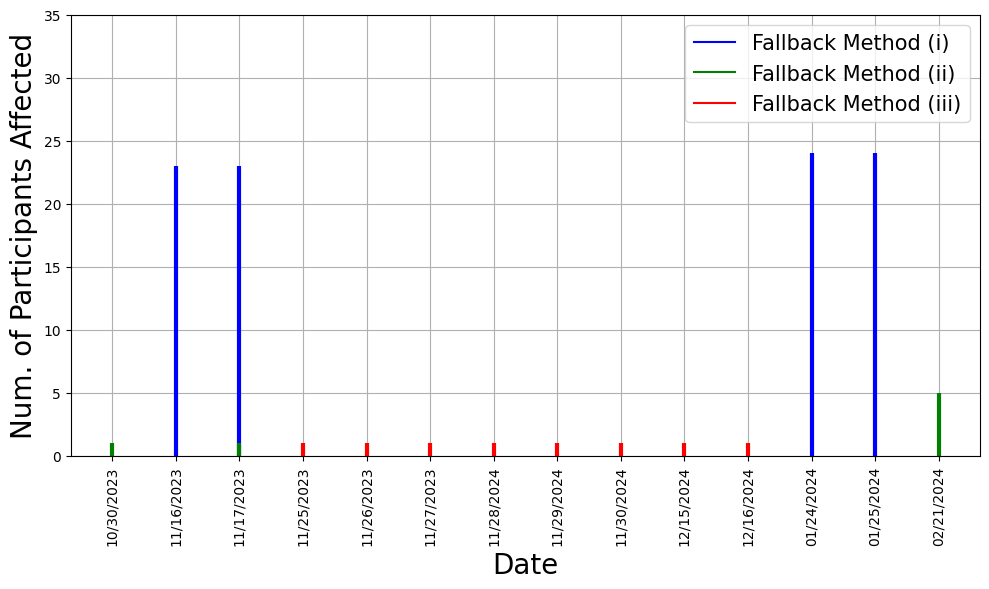

In [48]:
plt.figure(figsize=(10, 6))

category_colors = {
    1: 'blue',
    2: 'green',
    3: 'red'
}
fallback_methods_code = {
    1: 'Fallback Method (i)',
    2: 'Fallback Method (ii)',
    3: 'Fallback Method (iii)' 
}

handles = []
for i, row in engineering_issues_rl.iterrows():
    fb_code = row['Fallback Method Type']
    fb_name = fallback_methods_code[fb_code]
    handle = plt.vlines(
        x=row['Date'],
        ymin=0, 
        ymax=row['Num. Participants Affected'], 
        linewidth=3, 
        label=fb_name,
        colors=category_colors[fb_code]
    )
    handles.append(handle)

plt.xticks(rotation='vertical')
plt.xlabel('Date', size=20)
plt.ylabel('Num. of Participants Affected', size=20)
plt.ylim(0, 35)
# plt.title('Fallback Methods Over the Oralytics Trial', size=22)
# plt.title('Issues Over the Oralytics Trial', size=22)
plt.grid(True)

plt.legend(
    loc='best',
    handles=[plt.Line2D([0], [0], color=color, lw=1.5) for color in category_colors.values()], 
    labels=fallback_methods_code.values(), 
    fontsize=15
)

# Show the plot
plt.tight_layout()
plt.savefig('../../figs/fb_plot.pdf')
plt.show()

### [ANNA TODO] Issues

In [ ]:
plt.figure(figsize=(10, 6))

category_colors = {
    1: 'blue',
    2: 'green',
    3: 'red'
}
fallback_methods_code = {
    1: 'Fallback Method (i)',
    2: 'Fallback Method (ii)',
    3: 'Fallback Method (iii)' 
}

handles = []
for i, row in engineering_issues_rl.iterrows():
    fb_code = row['Fallback Method Type']
    fb_name = fallback_methods_code[fb_code]
    handle = plt.vlines(
        x=row['Date'],
        ymin=0, 
        ymax=row['Num. Participants Affected'], 
        linewidth=3, 
        label=fb_name,
        colors=category_colors[fb_code]
    )
    handles.append(handle)

plt.xticks(rotation='vertical')
plt.xlabel('Date', size=20)
plt.ylabel('Num. of Participants Affected', size=20)
plt.ylim(0, 35)
# plt.title('Issues Over the Oralytics Trial', size=22)
plt.grid(True)

plt.legend(
    loc='best',
    handles=[plt.Line2D([0], [0], color=color, lw=1.5) for color in category_colors.values()], 
    labels=fallback_methods_code.values(), 
    fontsize=15
)

# Show the plot
plt.tight_layout()
plt.savefig('../../figs/issues_plot.pdf')
plt.show()

## Did Pooling Help?
---

In [79]:
cumulative_quality_df = mrt_df.groupby(['user_id', 'user_start_day'])['quality'].sum().reset_index().sort_values(by='user_start_day')

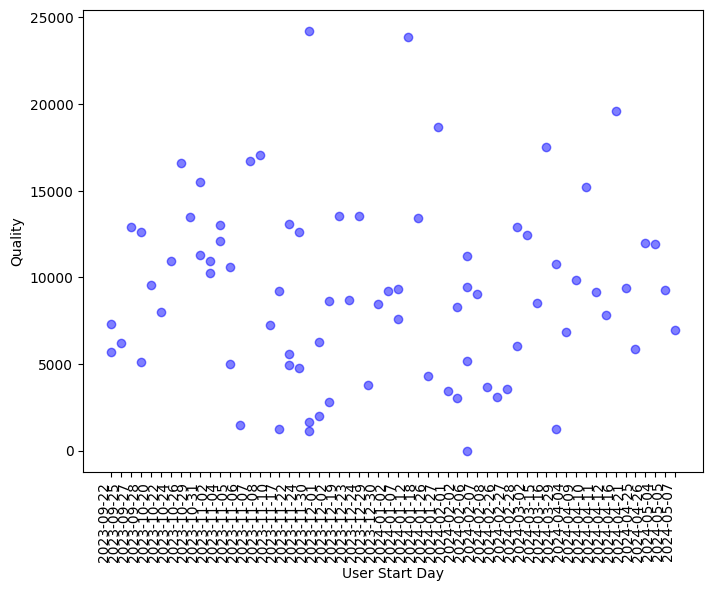

In [84]:
x = cumulative_quality_df['user_start_day']
y = cumulative_quality_df['quality']

# Plotting the scatter plot
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
plt.scatter(x, y, color='blue', alpha=0.5)  # Scatter plot with transparency (alpha=0.5)
plt.xlabel('User Start Day')
plt.xticks(rotation=90, ha='right', size=10)  # Rotate labels for better readability
plt.ylabel('Quality')
plt.show()

In [85]:
avg_quality_df = mrt_df.groupby(['user_id', 'user_start_day'])['quality'].mean().reset_index().sort_values(by='user_start_day')

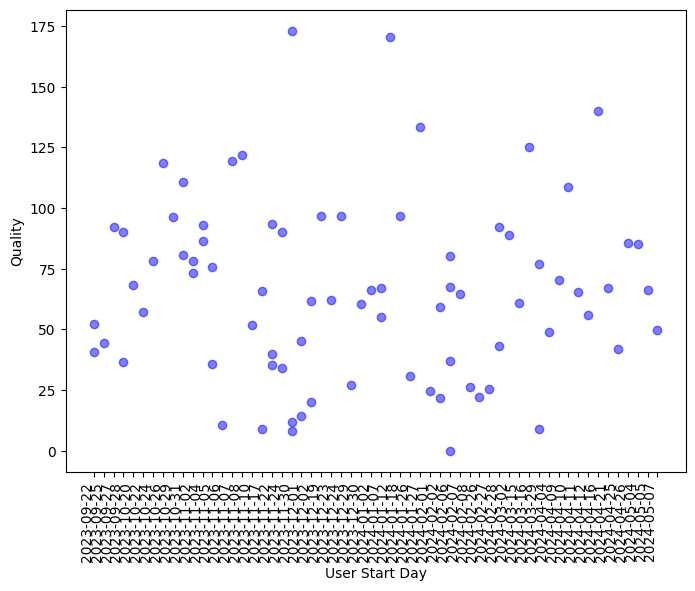

In [86]:
x = avg_quality_df['user_start_day']
y = avg_quality_df['quality']

# Plotting the scatter plot
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
plt.scatter(x, y, color='blue', alpha=0.5)  # Scatter plot with transparency (alpha=0.5)
plt.xlabel('User Start Day')
plt.xticks(rotation=90, ha='right', size=10)  # Rotate labels for better readability
plt.ylabel('Quality')
plt.show()

## Plot 1: Average Dosage per Day

Average curve of average dose per day (group by day in study). X-axis is day in study from september 2023 to june 2024. Y-axis is average number of times algorithm selected action 1 averaged across all decision points for that day across all users currently in the study.

Computation process: 
1. Calculate the number of data points per day. 
2. Calculate the total dosage per day (ie. across all users on a specific day, how many times did the algorithm select action 1)?
3. For each day, calculate average dosage as $\frac{\text{total dosage}}{\text{number of data points}}$


In [63]:
#Create dataframe with total dosage, num data points, and average dosage 
daily_data = (
    mrt_df.groupby('date')
      .agg({
          'action': 'sum',
          'user_id': 'size'
      })
      .rename(columns={
          'action':'total_dosage',
          'user_id':'num_data_points'
      })
      .reset_index()
)
daily_data['average_dosage'] = (daily_data['total_dosage']/daily_data['num_data_points']).round(3)
daily_data['date'] = pd.to_datetime(daily_data['date'])

#Create day in study column for cleaner visualization 
min_date = daily_data['date'].min()
daily_data['day_in_study'] = (daily_data['date'] - min_date).dt.days + 1

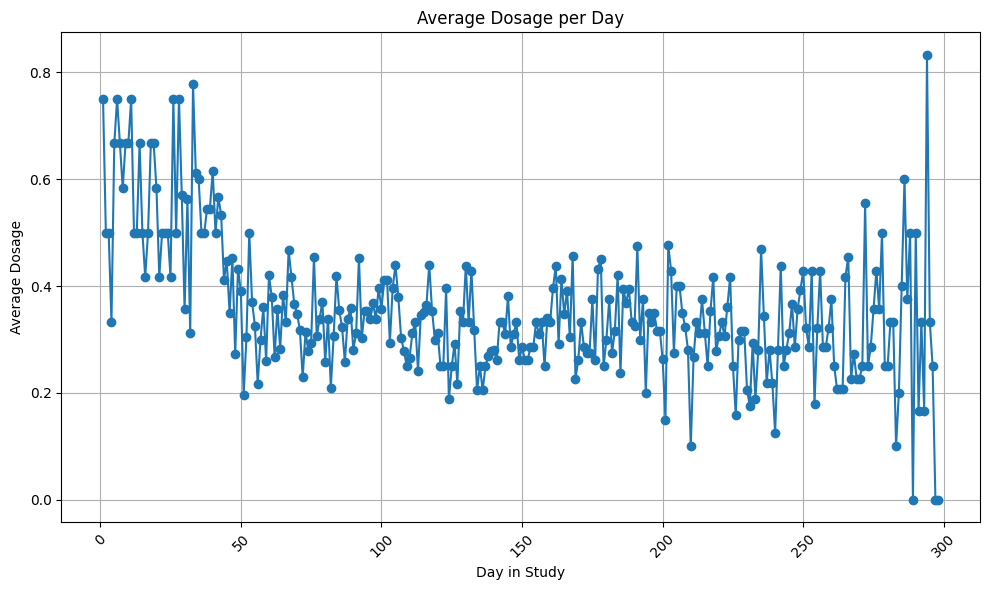

In [64]:
#Plot for average dosage per day
plt.figure(figsize=(10, 6))
plt.plot(daily_data['day_in_study'], daily_data['average_dosage'], marker='o')
plt.title('Average Dosage per Day')
plt.xlabel('Day in Study')
plt.ylabel('Average Dosage')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../../figs/average_dosage.pdf')
plt.show()

## Plot 2: Variance within Users

Variation within users across the state features (1) brushing quality, (2) number of times they opened the app, (3) $\bar{B}$ exponentially discounted brushing in past week.

Computation process: 
1. Choose one state feature.$^*$
2. For chosen feature, calculate the mean of the feature for each user. 
3. For chosen feature, calculate the standard deviation.
4. Calculate the confidence interval per user per feature as follows
$$CI = \bar{x} \pm z \frac{s}{\sqrt{n}}$$
where $\bar{x}$ is the mean calculated in step 2, $s$ is the standard deviation from step 3, and $n$ is the number of data points for each user.
5. Repeat steps 1-4 for all features.


$^*$ Note that this process is slightly different for the feature `number of times they opened the app` since that is only recorded once at a daily level (instead of twice, like the other features). Thus, $n$ for this feature is half of that for the other features.

In [6]:
sim_env_data = sim_env_data.sort_values(by=['user_id','date'],ascending=[True,True])

#Clean user ID column for better visualization
sim_env_data['user_id_short'] = sim_env_data['user_id'].str.extract(r'([^@]+)')

#Create app usage data from user app engagement column separately because it is recorded once daily
user_app_usage = (sim_env_data.
                  groupby([
                      'user_id_short','date'
                  ])
                  ['state_app_engage'].
                  mean().
                  reset_index())

#Create dataframe with mean value per feature per user 
mean_per_user = (sim_env_data.
                 groupby('user_id_short')
                 [['state_b_bar',
                     'quality'
                  ]].
                 mean().
                 reset_index())

#Repeat process of mean calculation for state app engagement feature
mean_per_user['state_app_engage'] = (user_app_usage.groupby
                                     ('user_id_short')
                                     ['state_app_engage'].
                                     mean().
                                     reset_index()
                                     ['state_app_engage'])

#Create dataframe with standard deviation of each feature per user 
std_per_user = (sim_env_data.
                groupby('user_id_short')
                [['state_b_bar',
                    'quality'
                ]]
                .std()
                .reset_index())

std_per_user['state_app_engage'] = (user_app_usage.
                                    groupby('user_id_short')
                                    ['state_app_engage'].
                                    std().
                                    reset_index()
                                    ['state_app_engage'])

#Create dataframe with number of data points for each feature per user 
num_points_user = (sim_env_data.
                   groupby
                   ('user_id_short')
                   [['state_b_bar','quality'
                    ]].
                   count().
                   reset_index())

num_points_user['state_app_engage'] = (user_app_usage.
                                       groupby('user_id_short')
                                       ['state_app_engage'].
                                       size().
                                       reset_index()
                                       ['state_app_engage'])

#Compute lower bound and upper bound of confidence interval using formula listed above
z = 1.96
for col in ['state_b_bar', 'quality', 'state_app_engage']:
    mean_per_user[f'lower_bound_{col}'] = mean_per_user[col] - (z * std_per_user[col] / np.sqrt(num_points_user[col]))
    mean_per_user[f'upper_bound_{col}'] = mean_per_user[col] + (z * std_per_user[col] / np.sqrt(num_points_user[col]))

/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/2355990662.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)
/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/2355990662.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)
/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/2355990662.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)


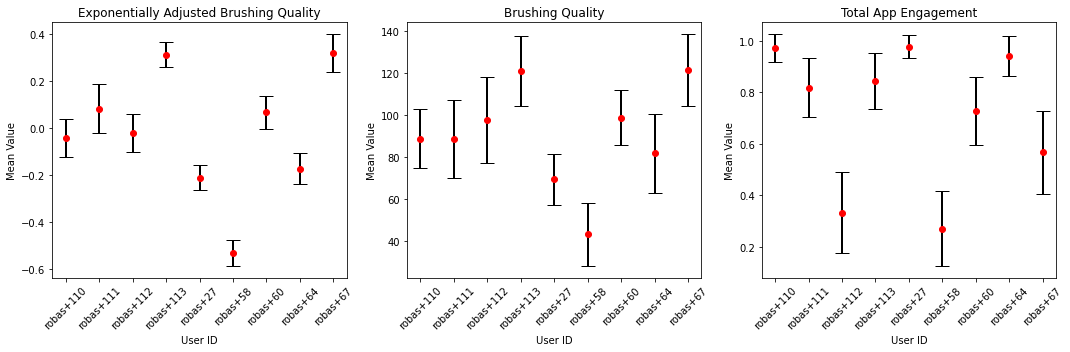

In [7]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

titles = {'state_b_bar':'Exponentially Adjusted Brushing Quality', 
          'quality':'Brushing Quality',
          'state_app_engage':'Total App Engagement'}

for i, col in enumerate(['state_b_bar', 'quality', 'state_app_engage']):
    ax = axes[i]
    ax.errorbar(
        mean_per_user['user_id_short'], 
        mean_per_user[col], 
        #confidence interval 
        yerr=[mean_per_user[col] - mean_per_user[f'lower_bound_{col}'],
              mean_per_user[f'upper_bound_{col}'] - mean_per_user[col]], 
        fmt='o', 
        color='red', 
        ecolor='black', 
        elinewidth=2, 
        capsize=7,
        label='Mean with 95% CI'
    )
    ax.set_title(titles[col])  
    ax.set_xlabel('User ID')
    ax.set_ylabel('Mean Value')
    ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)  

    # Annotate each bar with the corresponding value
    for bar, value in zip(ax.patches, mean_per_user[col]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.1f}', 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../../figs/var_within_users.pdf')
plt.show()


/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/3090567543.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)
/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/3090567543.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)
/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/3090567543.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)


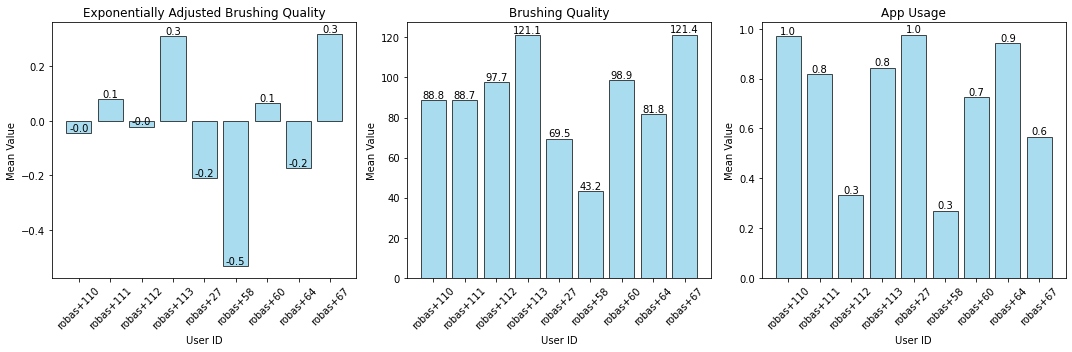

In [8]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

titles = {'state_b_bar':'Exponentially Adjusted Brushing Quality',
          'quality':'Brushing Quality',
          'state_app_engage':'App Usage'}

for i, col in enumerate(['state_b_bar', 'quality', 'state_app_engage']):
    ax = axes[i]
    ax.bar(mean_per_user['user_id_short'], mean_per_user[col], alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(titles[col]) 
    ax.set_xlabel('User ID')
    ax.set_ylabel('Mean Value')
    ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)  

    # Annotate each bar with the corresponding value
    for bar, value in zip(ax.patches, mean_per_user[col]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.1f}', 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Plot 3: Variance between users

How much variation there is between users (group by decision time). Compute variance and also have a plot for each statistic. Want average $X$ between users, where $X$ (1) is brushing quality, (2) number of times they opened the app, and (3) $\bar{B}$ exponentially discounted brushing in past week. For each plot, I am thinking x-axis is 70 users in the study and y-axis is each statistic for that user and we have some red line for mean and then dotted lines for upper and lower confidence (1.96 x SD).

Computation process: 
1. Choose feature. 
2. For each user, calculate the mean value for the feature. This produces a vector of values of size len(users).
3. Across all users, calculate the mean of the vector calculated in step 2. 
4. Across all users, calculate the standard deviation of the vector calculated in step 2.
5. Calculate the confidence interval per feature as follows
$$CI = \bar{x} \pm z \frac{s}{\sqrt{n}}$$
where $\bar{x}$ is the mean calculated in step 3, $s$ is the standard deviation from step 4, and $n$ is the number of users.
6. Repeat steps 1-5 for all state features.


to do:
- no x axis tiks, but still label as user id


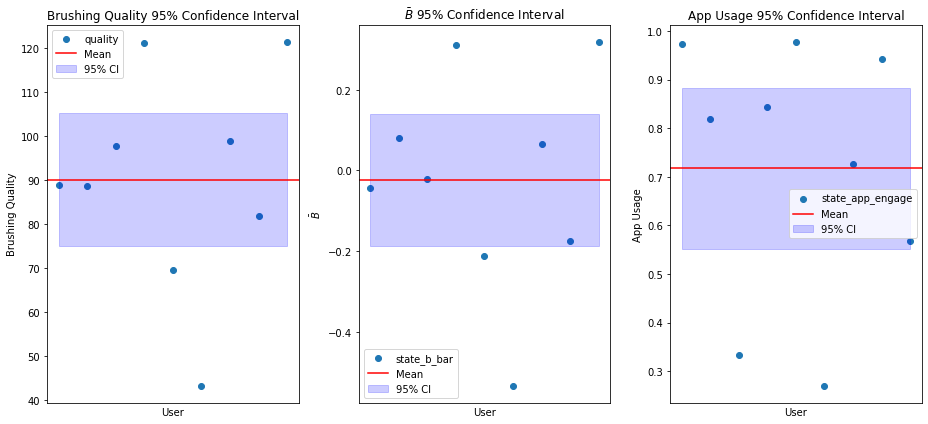

In [9]:
cols = ['quality', 'state_b_bar', 'state_app_engage']

titles = {'state_b_bar':r'$\bar{B}$', 
          'quality':'Brushing Quality',
          'state_app_engage':'App Usage'}

# Create a function to calculate the confidence interval
def mean_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std = np.std(data)
    n = len(data)
    h = std * 1.96 / np.sqrt(n)  # 1.96 is the z-score for 95% confidence
    return mean, mean - h, mean + h

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(13, 6))

# Plot each column
for i, col in enumerate(cols):
    data = mean_per_user[col]
    mean, lower, upper = mean_confidence_interval(data)
    
    axs[i].scatter(x= range(len(data)),y=data, label=col)
    axs[i].axhline(y=mean, color='r', linestyle='-', label='Mean')
    axs[i].fill_between(range(len(data)), lower, upper, color='b', alpha=0.2, label='95% CI')
    axs[i].set_title(f'{titles[col]} 95% Confidence Interval')
    axs[i].set_xlabel('User')
    axs[i].set_ylabel(f'{titles[col]}')
    axs[i].set_xticks([])
    axs[i].legend()

plt.tight_layout()
plt.savefig('../../figs/var_between_users.pdf')
plt.show()

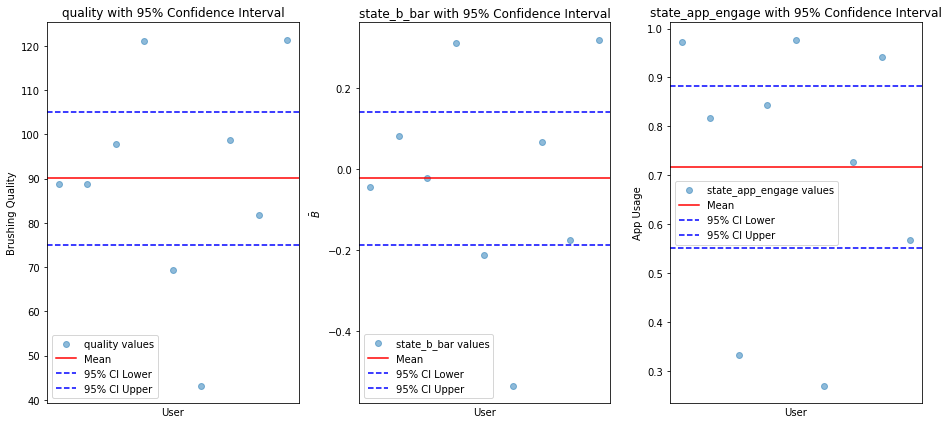

In [10]:
titles = {'state_b_bar':r'$\bar{B}$', 'quality':'Brushing Quality','state_app_engage':'App Usage'}

# Create a function to calculate the confidence interval
def mean_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std = np.std(data)
    n = len(data)
    h = std * 1.96 / np.sqrt(n)  # 1.96 is the z-score for 95% confidence
    return mean, mean - h, mean + h

# Create subplots with a different figsize to make plots narrower and taller
fig, axs = plt.subplots(1, 3, figsize=(13, 6))

# Plot each column
for i, col in enumerate(cols):
    data = mean_per_user[col]
    mean, lower, upper = mean_confidence_interval(data)
    
    axs[i].scatter(range(len(data)), data, alpha=0.5, label=f'{col} values')
    axs[i].axhline(y=mean, color='r', linestyle='-', label='Mean')
    axs[i].axhline(y=lower, color='b', linestyle='--', label='95% CI Lower')
    axs[i].axhline(y=upper, color='b', linestyle='--', label='95% CI Upper')
    axs[i].set_title(f'{col} with 95% Confidence Interval')
    axs[i].set_xlabel('User')
    axs[i].set_ylabel(f'{titles[col]}')
    axs[i].set_xticks([])
    axs[i].legend()
plt.tight_layout()
plt.show()